In [1]:
from molmap import model as molmodel
import molmap

import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(123)
tf.compat.v1.set_random_seed(123)


tmp_feature_dir = './tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)

RDKit WARNING: [19:37:32] Enabling RDKit 2019.09.2 jupyter extensions
/home/shenwanxiang/anaconda3/envs/deepchem23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type

In [2]:

mp1 = molmap.loadmap('../descriptor.mp')
mp2 = molmap.loadmap('../fingerprint.mp')


In [3]:
task_name = 'ESOL'

from chembench import load_data

df, induces = load_data(task_name)

loading dataset: ESOL number of split times: 3


In [4]:
smiles_col = df.columns[0]
values_col = df.columns[1:]
Y = df[values_col].astype('float').values
Y = Y.reshape(-1, 1)


X1_name = os.path.join(tmp_feature_dir, 'X1_%s.data' % task_name)
X2_name = os.path.join(tmp_feature_dir, 'X2_%s.data' % task_name)
if not os.path.exists(X1_name):
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)

if not os.path.exists(X2_name): 
    X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
    dump(X2, X2_name)
else:
    X2 = load(X2_name)

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]


In [5]:
epochs = 800
patience = 50 #early stopping

dense_layers = [256, 128, 32]
batch_size = 128
lr = 1e-4
weight_decay = 0

loss = 'mse'
monitor = 'val_loss'
dense_avf = 'relu'
last_avf = 'linear'


In [6]:
results = []

for i, split_idxs in enumerate(induces):

    train_idx, valid_idx, test_idx = split_idxs
    
    train_idx = [i for i in train_idx if i < len(df)]
    valid_idx = [i for i in valid_idx if i < len(df)]    
    test_idx = [i for i in test_idx if i < len(df)]
    
    print(len(train_idx), len(valid_idx), len(test_idx))

    trainX = (X1[train_idx], X2[train_idx])
    trainY = Y[train_idx]

    validX = (X1[valid_idx], X2[valid_idx])
    validY = Y[valid_idx]

    testX = (X1[test_idx], X2[test_idx])
    testY = Y[test_idx]            


    model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                       n_outputs=Y.shape[-1], 
                                       dense_layers=dense_layers, 
                                       dense_avf = dense_avf, 
                                       last_avf=last_avf)

    opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
    #import tensorflow_addons as tfa
    #opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = loss)
    

    if i == 0:
        performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                                   (validX, validY), 
                                                                   patience = patience, 
                                                                   criteria = monitor)
        model.fit(trainX, trainY, batch_size=batch_size, 
              epochs=epochs, verbose= 0, shuffle = True, 
              validation_data = (validX, validY), 
              callbacks=[performance]) 
    else:
        model.fit(trainX, trainY, batch_size=batch_size, 
              epochs = performance.best_epoch + 1, verbose = 1, shuffle = True, 
              validation_data = (validX, validY)) 
            
    performance.model.set_weights(model.get_weights())
    
    best_epoch = performance.best_epoch
    trainable_params = model.count_params()

    train_rmses, train_r2s = performance.evaluate(trainX, trainY)            
    valid_rmses, valid_r2s = performance.evaluate(validX, validY)            
    test_rmses, test_r2s = performance.evaluate(testX, testY)


    final_res = {
                 'task_name':task_name,            
                 'train_rmse':np.nanmean(train_rmses), 
                 'valid_rmse':np.nanmean(valid_rmses),                      
                 'test_rmse':np.nanmean(test_rmses), 

                 'train_r2':np.nanmean(train_r2s), 
                 'valid_r2':np.nanmean(valid_r2s),                      
                 'test_r2':np.nanmean(test_r2s), 

                 '# trainable params': trainable_params,
                 'best_epoch': best_epoch,
                 'batch_size':batch_size,
                 'lr': lr,
                 'weight_decay':weight_decay
                }
    results.append(final_res)
    

902 113 113
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 0001, loss: 12.7995 - val_loss: 9.8648; rmse: 3.3294 - rmse_val: 3.1408;  r2: 0.0765 - r2_val: 0.0692                                                                                                    
epoch: 0002, loss: 9.5679 - val_loss: 5.8446; rmse: 2.6022 - rmse_val: 2.4176;  r2: 0.0950 - r2_val: 0.0980                                                                                                    
epoch: 0003, loss: 5.2939 - val_loss: 3.8008; rmse: 2.0448 - rmse_val: 1.9496;  r2: 0.1045 - r2_val: 0.1122                                                                                                    
epoch: 0004, loss: 4.3866 - val_loss: 3.8655; rmse: 2.0495 - rmse_val: 1.9661;  r2: 0.1265 - r2_val: 0.1409                                                                                                    
epoch: 0005, loss: 4.0359 - val_loss:

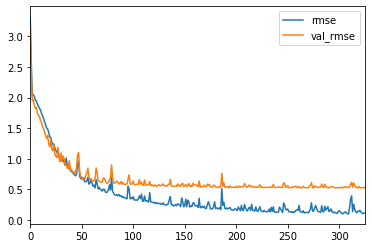

In [7]:
pd.DataFrame(performance.history)[['rmse', 'val_rmse']].plot()

In [8]:
pd.DataFrame(results).test_rmse.mean()

0.5747852737384287

In [9]:
pd.DataFrame(results).test_rmse.std()

0.06382945181346295

In [10]:
pd.DataFrame(results).to_csv('./results/%s.csv' % task_name)

In [11]:
pd.DataFrame(results)

,task_name,train_rmse,valid_rmse,test_rmse,train_r2,valid_r2,test_r2,# trainable params,best_epoch,batch_size,lr,weight_decay
0,ESOL,0.146218,0.523291,0.647990,0.996040,0.932177,0.889020,803681,275,128,0.0001,0
1,ESOL,0.126394,0.585173,0.545599,0.996736,0.933716,0.935269,803681,275,128,0.0001,0
2,ESOL,0.207896,0.631244,0.530767,0.996399,0.902215,0.935536,803681,275,128,0.0001,0
